## Importing the associated modules

In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as npr
import functools
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import metrics, linear_model, ensemble, neural_network, svm, dummy
from helpers import *

# Importing the different features
from ema_features import get_EMA_features_and_target_for_patient, read_EMA_code, init_EMA_patient
from module_features import get_module_features_for_patient, read_module_data
from context_features import get_weekend_days

# Importing the machine learning module
from predicting import train_algorithms, test_algorithms, eval_algorithms, plot_algorithms, make_algorithms
from feature_selection import backward_selection, forward_selection, correlate_features, precalculated_feature_selection

# Importing multiple patient wrapper
from individual_wrappers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initializing constants

In [13]:
SLIDING_WINDOW = 7
RIDGE_ALPHAS = (0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7)
LASSO_ALPHAS = (0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5)
MAX_PATIENTS = 10
FEATURE_PATH = "data/features/"

## Defining our Machine Learning Algorithms

In [ ]:
ml_algorithms = [
    {
        "name": "Lasso",
        "model": linear_model.LassoCV(alphas=LASSO_ALPHAS)
    },
    {
        "name": "Ridge",
        "model": linear_model.RidgeCV(alphas=RIDGE_ALPHAS)
    },
    {
        "name": "Random Forest",
        "model": ensemble.RandomForestRegressor(n_estimators=1000, max_depth=2)
    },
    {
        "name": "Dummy Mean Regressor",
        "model": dummy.DummyRegressor()
    },
    {
        "name": "SVR RBF",
        "model": svm.SVR()
    }
]

## Initializing patients

In [14]:
proper_patients = get_proper_patients()

In [15]:
module_patients = read_module_data()

In [ ]:
ema_patients = read_EMA_code()

# Methodology

### Retrieving the working patients

In [ ]:
ids = module_patients['ECD_ID'].unique().tolist()

results_freq = []

for id in ids:
    considered_df = init_patient(module_patients, id)
    daily_df = considered_df.resample('1d').count()
    daily_df = daily_df.drop(daily_df[daily_df['ECD_ID'] == 0].index)
    results_freq.append((id, len(daily_df)))
# ema_patients.groupby('ECD_ID').count().sort_values(by='xEmaSchedule', ascending=False)

In [ ]:
ema_ids = ema_patients['ECD_ID'].unique().tolist()

EMA_results_freq = []

for id in ema_ids:
    considered_EMA_df = init_EMA_patient(ema_patients, id)
    daily_EMA_df = considered_EMA_df.resample('1d').count()
    daily_EMA_df = daily_EMA_df.drop(daily_EMA_df[daily_EMA_df['xEmaSchedule'] == 0].index)
    EMA_results_freq.append(len(daily_EMA_df))

In [ ]:
results_freq_only_mod = [i[1] for i in results_freq]

In [ ]:
bins = np.arange(0, 300, 25)
inds = np.digitize(results_freq_only_mod, bins)
plt.hist(results_freq_only_mod, bins)
plt.title('Day counts for patient module usage')
plt.ylabel('Frequency')
plt.xlabel('Days logged')
plt.savefig('Mod_count')
# results_freq_only_mod

In [ ]:
import seaborn as sns
# EMA_test = EMA_results_freq[:10]

EMA_bins = np.arange(0, 300, 25)
# EMA_inds = np.digitize(EMA_test, EMA_bins)
# EMA_results_freq

# np.sort(EMA_results_freq[])

# check_EMA = np.sort(EMA_results_freq[:5])
# hist, bins = np.histogram(check_EMA)
EMA_test2 = np.sort(EMA_results_freq)

plt.hist(np.array(EMA_test2[:-5]), EMA_bins, color='skyblue')
plt.title('Day counts for patient EMA usage')
plt.ylabel('Frequency')
plt.xlabel('Days logged')
plt.savefig('EMA_count')

## Condition A: Per-patient

In [ ]:
patients_features = [get_features_for_patient(patient['patient_id']) for patient in proper_patients]

In [ ]:
make_models = [make_algorithms(ml_algorithms, patient[0], patient[1]) for patient in patients_features]

## Condition B: Population-based

### Gathering all patients

In [ ]:
patients_performances = [get_features_for_patient(patient['patient_id']) for patient in sample_patients]

### Adding all dataframes together

In [ ]:
patient_ids = [patient['patient_id'] for patient in sample_patients]
patients_features = [feature_set[0] for feature_set in patients_performances]
patients_targets = [feature_set[1] for feature_set in patients_performances]

patients_features[1]

for i, (j,k) in enumerate(zip(patients_features, patient_ids)):
    patients_features[i]['patient_id'] = patient_ids[i]

In [ ]:
patients_performances_combined = reduce(lambda x,y: x.append(y), patients_features)
patients_targets_combined = reduce(lambda x,y: x.append(y), patients_targets)

In [ ]:
patients_performances_combined = patients_performances_combined.drop('test', axis=1)

In [ ]:
ridgeTest = linear_model.RidgeCV(alphas=RIDGE_ALPHAS)
split_index = int(len(patients_performances_combined) * 0.66)

patients_performance_combined_two = patients_performances_combined.drop('prior_engagement')

# patients_performance_combined_two

ridgeTest.fit(patients_performance_combined_two, patients_targets_combined)

patients_total = patients_performances_combined.join(patients_targets_combined)
sample_patient_x = patients_total[patients_total['patient_id'] == '102066']
sample_patient_x = sample_patient_x.drop('prior_engagement', axis=1)
sample_patient_y = patients_total[patients_total['patient_id'] == '102066']['prior_engagement']

In [ ]:
# sample_patient_x = sample_patient_x.drop('prior_engagement', axis=1)
# sample_patient_x
# _, _, test_x, test_y = split_dataset(sample_patient_x, sample_patient_y, split_index)

prediction = ridgeTest.predict(sample_patient_x)
sample_patient_y

metrics.mean_absolute_error(prediction, sample_patient_y)

# trained_models = train_algorithms([{'model':ridgeTest, 'name': 'Ridge'}], patients_performances_combined, patients_targets_combined)
# tested_models = test_algorithms(trained_models, test_x)
# evaled_models = eval_algorithms(trained_models, test_y)
# eval_algorithm(ridgeTest, test_y)

In [ ]:
ridgeTest2 = RidgeCV(alphas=RIDGE_ALPHAS)

In [ ]:
patient_x = pati

## Feature Selection

In [ ]:
top_features, performances = create_patient_features(proper_patients[1:4], ml_algorithms, max_features=20)
# top_features

# plt.plot([1,2,3], [2.3, 4.6, 6.7])

In [ ]:
plt.plot(a,b)

## Evaluation

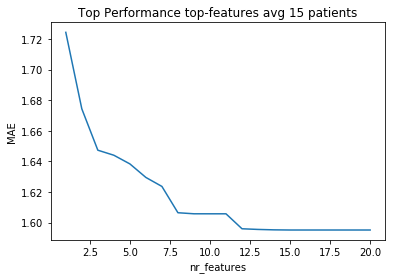

In [22]:
import seaborn as sns
def plot_performance(performance_tuple, patient_id='', title_subject='Top Performance top-features avg 15 patients'):
    x = [i for i in performance_tuple[0]]
    y = [i for i in performance_tuple[1]]
    plt.title(title_subject)
    plt.xlabel('nr_features')
    plt.ylabel('MAE')
    plt.plot(x,y)
    plt.savefig('feature_performances_'+patient_id)
performances = load_patient_object('102318', prefix='fs').tolist()['performances']

plot_performance(performances, '102318')

### Convert the performance results to one DataFrame

In [ ]:
topf_avg_performance = calc_avg_performance_from_models(ml_algorithms, end_results[0])
fcorrelation_avg_performance = calc_avg_performance_from_models(ml_algorithms, end_results[1])
allf_avg_performance = calc_avg_performance_from_models(ml_algorithms, end_results[2])
topf_df = pd.DataFrame(topf_avg_performance)
topf_df['feature_setup'] = pd.Series(['top_features' for i in range(1, len(topf_avg_performance) + 1)])

allf_df = pd.DataFrame(allf_avg_performance)
allf_df['feature_setup'] = pd.Series(['all_features' for i in range(1, len(allf_avg_performance) + 1)])
allf_df

corrf_df = pd.DataFrame(fcorrelation_avg_performance)
corrf_df['feature_setup'] = pd.Series(['corr_features' for i in range(1, len(fcorrelation_avg_performance) + 1)])

grouped_performances = topf_df.append(allf_df).append(corrf_df)
groupby_statement = grouped_performances.groupby('feature_setup').mean()
groupby_statement